## License
```
Satellite frames.
Copyright (C) 2019+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
```

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D
# for animations, you may need to install "ffmpeg" and/or "imagemagick"
from matplotlib import animation, rc

import cysgp4

rc('animation', html='html5')

If you plan to make big movies (i.e., large file sizes), you may need to start Jupyter with the command line option ``--NotebookApp.iopub_data_rate_limit=1.0e10`` and do the following:

In [2]:
# matplotlib.rcParams['animation.embed_limit'] = 2 ** 128

From the FCC filing of the Starlink constellation, we know at which altitudes, inclinations etc. the satellites will be operated. From this information, we need to produce TLEs, in order to process them with the SGP4 software. For example:

In [3]:
# want epoch for the following time
mjd_epoch = 58813.5
pydt = cysgp4.PyDateTime.from_mjd(mjd_epoch)
pydt

<PyDateTime: 2019-11-26 12:00:00.000000 UTC>

Note, the TLE uses a special format for the date/time:

In [4]:
pydt.tle_epoch

19330.5

But the `tle_linestrings_from_orbital_parameters` works with standard MJD:

In [5]:
sat_name, sat_nr = 'MYSAT', 1
alt_km = 3000.  # satellite altitude
mean_motion = cysgp4.satellite_mean_motion(alt_km)
print('mean motion (rev / day)', mean_motion)
inclination = 30.  # deg
raan = 90.  # deg
eccentricity = 0.0001
argument_of_perigee = 0.  # deg
mean_anomaly = 112.  # deg

tle_tuple = cysgp4.tle_linestrings_from_orbital_parameters(
    sat_name,
    sat_nr,
    mjd_epoch,
    inclination,
    raan,
    eccentricity,
    argument_of_perigee,
    mean_anomaly,
    mean_motion
    )

tle_tuple

mean motion (rev / day) 9.559347225355461


('MYSAT',
 '1 00001U 20001A   19330.50000000  .00000000  00000-0  50000-4 0    07',
 '2 00001  30.0000  90.0000 0001000   0.0000 112.0000  9.55934723    07')

To check, that this is working as intended:

In [6]:
my_tle = cysgp4.PyTle(*tle_tuple)
# want position at a given time, which can of course differ from the epoch
obs_dt = cysgp4.PyDateTime.from_mjd(58814.23)
my_sat = cysgp4.Satellite(my_tle)
my_sat.pydt = obs_dt
my_sat.eci_pos()  # in Geodetic frame

<PyEci: 48.9509d, 28.6962d, 2999.8492km 2019-11-27 05:31:12.000000 UTC>

From the ECI position and the motion vector, it is possible to construct a Cartesian coordinate system for the satellite, in which $y$ is the position across (perpendicular to) the satellite track, $z$ is along the satellite track, and $x$ is in Nadir direction.

In [7]:
my_sat.eci_pos().loc, my_sat.eci_pos().vel

((-7845.140126693372, -2488.8972039962855, 4484.83534439121),
 (1.4540882207457848, -6.289015746770166, -0.9432011616878053))

The base vectors (expressed in the ECI system) are:

In [8]:
e_z = my_sat.eci_pos().vel / np.linalg.norm(my_sat.eci_pos().vel)
e_x = -(my_sat.eci_pos().loc / np.linalg.norm(my_sat.eci_pos().loc))
e_y = np.cross(e_z, e_x)

In [9]:
e_x, e_y, e_z

(array([ 0.83698659,  0.26553682, -0.47848056]),
 array([ 0.49967642, -0.01436256,  0.86609303]),
 array([ 0.22290088, -0.96405922, -0.1445857 ]))

We can double check, if the system is orthogonal:

In [10]:
np.dot(e_x, e_y), np.dot(e_y, e_z), np.dot(e_z, e_x)

(5.551115123125783e-17, 0.0, -0.00024672409792618477)

... which is not quite the case, because the orbit is not purely circular (therefore, ECI loc and vel are not strictly orthogonal). However, for most purposes, this can probably neglected. Otherwise, one could use $e_x$ and one of $e_y$ or $e_z$ to construct a truely orthogonal system (depending on which of the directions one is interested in). Here, we choose to "correct" the nadir direction, because it is more likely that the satellite frame will be tied to the motion of the satellite instead of to the Earth's center.

In reality, it gets a little bit more complicated, [see here](https://space.stackexchange.com/questions/19727/in-spacecraft-talk-is-nadir-just-a-fancy-word-for-down).

In [11]:
e_y = e_y / np.linalg.norm(e_y)
e_x = np.cross(e_y, e_z)
e_x

array([ 0.83704161,  0.26529897, -0.47851625])

In [12]:
np.dot(e_x, e_y), np.dot(e_y, e_z), np.dot(e_z, e_x)

(0.0, 0.0, -1.3877787807814457e-17)

Let's do some visualizations...

In [13]:
tles = np.array([my_tle])

In [14]:
start_mjd = mjd_epoch
td = np.arange(0, 86400 / mean_motion, 60) / 86400.  # one orbit in steps of 1 min
mjds = start_mjd + td

In [15]:
# Effelsberg 100-m radio telescope
effbg_observer = cysgp4.PyObserver(6.88375, 50.525, 0.366)
observers = np.array([effbg_observer])

In [16]:
result = cysgp4.propagate_many(
    mjds,
    my_tle,
    effbg_observer,
    do_obs_pos=True, do_sat_azel=True,
    )

In [17]:
eci_locs, eci_vels = result['eci_pos'], result['eci_vel']
obs_pos, sat_azel = result['obs_pos'], result['sat_azel']

In [18]:
e_zs = eci_vels / np.linalg.norm(eci_vels, axis=1)[:, np.newaxis]
e_xs = -eci_locs / np.linalg.norm(eci_locs, axis=1)[:, np.newaxis]
e_ys = np.cross(e_zs, e_xs)
e_ys = e_ys / np.linalg.norm(e_ys, axis=1)[:, np.newaxis]
e_xs = np.cross(e_ys, e_zs)

In [19]:
eci_pos_x, eci_pos_y, eci_pos_z = (eci_locs[:, i] for i in range(3))

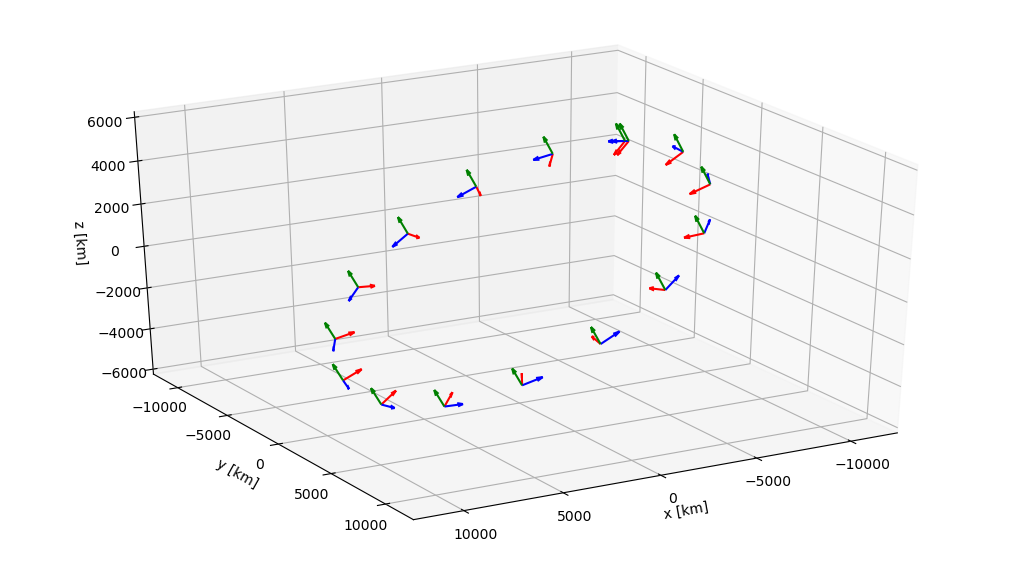

In [20]:
plim = 6000
fig = plt.figure(figsize=(12.8, 7.2), dpi=100)
ax = fig.add_subplot(111, projection='3d')  # 3D axes
ax.view_init(azim=60, elev=30)
ax.set_xlim((-2 * plim, 2 * plim))
ax.set_ylim((-2 * plim, 2 * plim))
ax.set_zlim((-plim, plim))
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')

for c, e in [('r', e_xs), ('g', e_ys), ('b', e_zs)]:
    ax.quiver(
        eci_pos_x[::10], eci_pos_y[::10], eci_pos_z[::10],
        1000 * e[::10, 0], 1000 * e[::10, 1], 1000 * e[::10, 2],
        color=c,
        )
plt.show()

In [21]:
my_time = cysgp4.PyDateTime()
my_time.mjd = mjds[0]
plim = 6000
vlen = 1000

# The figure size should make such that one gets a nice pixel canvas
# that fits the standard movie sizes (at given dpi):
#    854 x  480  (480p) --> figsize=(8.54, 4.8), dpi=100
#   1280 x  720  (720p) --> figsize=(12.8, 7.2), dpi=100
#   1920 x 1080 (1080p) --> figsize=(12.8, 7.2), dpi=150
#   3840 x 2160    (4K) --> figsize=(12.8, 7.2), dpi=300
# so basically, divide desired width and height with dpi
# (beware, 4K videos get large and need a lot of RAM!)
fig = plt.figure(figsize=(8.54, 4.8), dpi=100)
ax = fig.add_subplot(111, projection='3d')  # 3D axes
ax.view_init(azim=60, elev=30)
# Aspect ratio is  not implemented; 
# see https://github.com/matplotlib/matplotlib/issues/1077/
# ax.set_aspect('equal')
# need to manually stretch to make it approx. right
ax.set_xlim((-2 * plim, 2 * plim))
ax.set_ylim((-2 * plim, 2 * plim))
ax.set_zlim((-plim, plim))
# ax.auto_scale_xyz([-2 * plim, 2 * plim], [-2 * plim, 2 * plim], [-plim, plim])
# axisEqual3D(ax)
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')

rads = np.sqrt(eci_pos_x ** 2 + eci_pos_y ** 2 + eci_pos_z ** 2)
points = ax.scatter(
    eci_pos_x[0:1], eci_pos_y[0:1], eci_pos_z[0:1],
    c=rads[0:1], s=1, vmin=rads.min(), vmax=rads.max(), marker='o'
    )
quivers = [
    ax.quiver(
        eci_pos_x[0], eci_pos_y[0], eci_pos_z[0],
        vlen * e[0, 0], vlen * e[0, 1], vlen * e[0, 2],
        color=c,
        )
    for c, e in [('r', e_xs), ('g', e_ys), ('b', e_zs)]
    ]

title = ax.set_title('{:%y/%m/%d %H:%M:%S}'.format(my_time.datetime), loc='center', fontsize=20)

def animate(i):
    global quivers
    points._offsets3d = (eci_pos_x[i:i+1], eci_pos_y[i:i+1], eci_pos_z[i:i+1])
    for q in quivers:
        try:
            q.remove()
        except:
            pass
    quivers = [
        ax.quiver(
            eci_pos_x[i], eci_pos_y[i], eci_pos_z[i],
            vlen * e[i, 0], vlen * e[i, 1], vlen * e[i, 2],
            color=c,
            )
        for c, e in [('r', e_xs), ('g', e_ys), ('b', e_zs)]
        ]
    my_time.mjd = mjds[i]
    title.set_text('{:%y/%m/%d %H:%M:%S}'.format(my_time.datetime))
    return points, title

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(
    fig, animate, frames=eci_pos_x.shape[0], interval=20, blit=True
    )

# this takes a while!
plt.close(anim._fig)
anim

In [22]:
# FFwriter = animation.FFMpegWriter(
#     fps=30, bitrate=8000,
#     extra_args=['-vcodec', 'libx264'],
#     )
# anim.save('satellite_frames_720p.mp4', writer=FFwriter)

Next, we want to calculate the observer position (located on Earth) in the azimuth/elevation frame of the satellite. For this, we need to project the difference vector of the ECI positions of the observer and the satellite onto the three satellite frame base vectors. Afterwards, we can convert to azimuth and elevation (and distance).

In [23]:
effbg_observer_eci = np.array([
    cysgp4.PyEci(cysgp4.PyDateTime.from_mjd(mjd), effbg_observer.loc).loc
    for mjd in mjds
    ])
# also provided directly from the propagate_many method:
# effbg_observer_eci = obs_pos
effbg_pos_x, effbg_pos_y, effbg_pos_z = (effbg_observer_eci[:, i] for i in range(3))

In [24]:
b_x = np.einsum('ki,ki->k', effbg_observer_eci - eci_locs, e_xs)
b_y = np.einsum('ki,ki->k', effbg_observer_eci - eci_locs, e_ys)
b_z = np.einsum('ki,ki->k', effbg_observer_eci - eci_locs, e_zs)

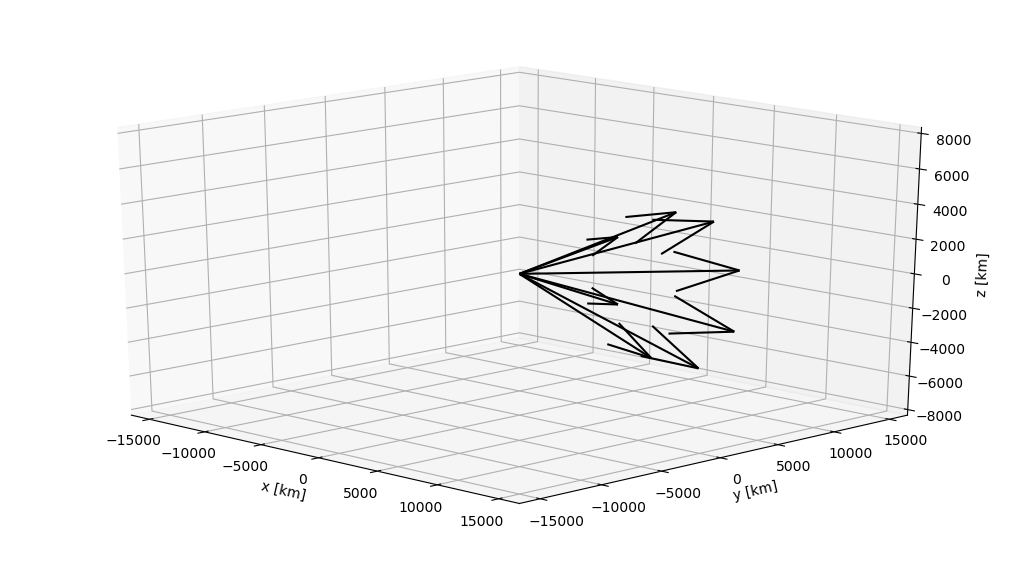

In [25]:
plim = 8000
fig = plt.figure(figsize=(12.8, 7.2), dpi=100)
ax = fig.add_subplot(111, projection='3d')  # 3D axes
ax.view_init(azim=-45, elev=20)
ax.set_xlim((-2 * plim, 2 * plim))
ax.set_ylim((-2 * plim, 2 * plim))
ax.set_zlim((-plim, plim))
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')

ax.quiver(
    0., 0., 0.,
    b_x[::20], b_y[::20], b_z[::20],
    color='k',
    )
plt.show()

In [26]:
sat_d = np.sqrt(b_x ** 2 + b_y ** 2 + b_z ** 2)
sat_el = 90 - np.degrees(np.arccos(b_z / sat_d))
sat_az = np.degrees(np.arctan2(b_y, b_x))

# also provided directly from the propagate_many method:
# sat_az, sat_el, sat_d = (sat_azel[..., i] for i in range(3))

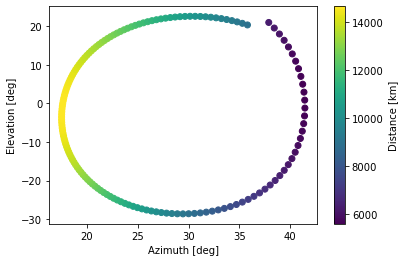

In [27]:
plt.close()
plt.scatter(sat_az, sat_el, c=sat_d)
cbar = plt.colorbar()
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
cbar.set_label('Distance [km]')
plt.show()

The following animation visualizes the projected components of the vector (observer-satellite) on the satellite frame base vectors. The length of the three r/g/b arrows is changed accordingly.

In [28]:
my_time = cysgp4.PyDateTime()
my_time.mjd = mjds[0]
plim = 6000

# The figure size should make such that one gets a nice pixel canvas
# that fits the standard movie sizes (at given dpi):
#    854 x  480  (480p) --> figsize=(8.54, 4.8), dpi=100
#   1280 x  720  (720p) --> figsize=(12.8, 7.2), dpi=100
#   1920 x 1080 (1080p) --> figsize=(12.8, 7.2), dpi=150
#   3840 x 2160    (4K) --> figsize=(12.8, 7.2), dpi=300
# so basically, divide desired width and height with dpi
# (beware, 4K videos get large and need a lot of RAM!)
fig = plt.figure(figsize=(8.54, 4.8), dpi=100)
ax = fig.add_subplot(111, projection='3d')  # 3D axes
ax.view_init(azim=60, elev=30)
# Aspect ratio is  not implemented; 
# see https://github.com/matplotlib/matplotlib/issues/1077/
# ax.set_aspect('equal')
# need to manually stretch to make it approx. right
ax.set_xlim((-2 * plim, 2 * plim))
ax.set_ylim((-2 * plim, 2 * plim))
ax.set_zlim((-plim, plim))
# ax.auto_scale_xyz([-2 * plim, 2 * plim], [-2 * plim, 2 * plim], [-plim, plim])
# axisEqual3D(ax)
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')

rads = np.sqrt(eci_pos_x ** 2 + eci_pos_y ** 2 + eci_pos_z ** 2)
points = ax.scatter(
    eci_pos_x[0:1], eci_pos_y[0:1], eci_pos_z[0:1],
    c=rads[0:1], s=1, vmin=rads.min(), vmax=rads.max(), marker='o'
    )
opoints = ax.scatter(
    effbg_pos_x[0:1], effbg_pos_y[0:1], effbg_pos_z[0:1],
    c=rads[0:1], s=1, vmin=rads.min(), vmax=rads.max(), marker='o'
    )
quivers1 = [
    ax.quiver(
        eci_pos_x[0], eci_pos_y[0], eci_pos_z[0],
        b_x[0] * e[0, 0], b_y[0] * e[0, 1], b_z[0] * e[0, 2],
        color=c,
        )
    for c, e in [('r', e_xs), ('g', e_ys), ('b', e_zs)]
    ]
quiver2 = ax.quiver(
    eci_pos_x[0], eci_pos_y[0], eci_pos_z[0],
    effbg_pos_x[0], effbg_pos_y[0], effbg_pos_z[0],
    color='c',
    )

title = ax.set_title('{:%y/%m/%d %H:%M:%S}'.format(my_time.datetime), loc='center', fontsize=20)

def animate(i):
    global quivers1, quiver2, opoints
    points._offsets3d = (eci_pos_x[i:i+1], eci_pos_y[i:i+1], eci_pos_z[i:i+1])
    opoints._offsets3d = (effbg_pos_x[i:i+1], effbg_pos_y[i:i+1], effbg_pos_z[i:i+1])
    for q in quivers1:
        q.remove()
    quiver2.remove()
    quivers1 = [
        ax.quiver(
            eci_pos_x[i], eci_pos_y[i], eci_pos_z[i],
            vlen[i] * e[i, 0], vlen[i] * e[i, 1], vlen[i] * e[i, 2],
            color=c,
            )
        for c, e, vlen in [('r', e_xs, b_x), ('g', e_ys, b_y), ('b', e_zs, b_z)]
        ]
    quiver2 = ax.quiver(
        eci_pos_x[i], eci_pos_y[i], eci_pos_z[i],
        (effbg_pos_x - eci_pos_x)[i],
        (effbg_pos_y - eci_pos_y)[i],
        (effbg_pos_z - eci_pos_z)[i],
        color='c',
        )
    my_time.mjd = mjds[i]
    title.set_text('{:%y/%m/%d %H:%M:%S}'.format(my_time.datetime))
    return points, opoints, title

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(
    fig, animate, frames=eci_pos_x.shape[0], interval=20, blit=True
    )

# this takes a while!
plt.close(anim._fig)
anim

In [29]:
#